Similar to 4.1 series, but 4 layers instead of 3.

Fix the random value.

In [51]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

In [52]:
REAL_LABEL = 1
FAKE_LABEL = 0
OUT_DIM = 4
n_qubits = OUT_DIM * 3

is_local_simulator = True

g_repeats_1  = 1
g_repeats_2  = 4
g_batch_size = 32
d_batch_size = 32

d_repeats = 1

n_epoch = 20
epoch_1 = 10

d_pretrain_epoch = 5

n_layers = 4
final_rotation_layer = True

lr = 2e-3


spsa_alpha = 0.05
spsa_gamma = 0.01
spsa_c     = 0.05
spsa_A     = 2e4
spsa_a1    = 2e-4
spsa_a     = spsa_a1 * (spsa_A + 1) ** spsa_alpha


name = "qgan-4.3"

save_folder = f"saved/{name}"

data_path = "dataset/dataset.npy"

seed = 2



In [53]:
if os.path.exists(save_folder):
    print(f"This notebook may overwrite previous results in the {save_folder} directory")
else:
    os.makedirs(save_folder)

rng = np.random.default_rng(seed)

# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)


This notebook may overwrite previous results in the saved/qgan-4.3 directory


In [54]:
data_true = np.load(data_path)
rng.shuffle(data_true)
data_true = torch.tensor(data_true, dtype = torch.float32, device=device, requires_grad=False)
data_loader = torch.utils.data.DataLoader(data_true, batch_size=d_batch_size, shuffle = True)

In [55]:
if n_qubits %2 != 0:
    raise ValueError("Odd number of qubits not supported right now.")

n_1q_parameters = 2 * n_qubits * (2 * n_layers + 1) if final_rotation_layer else  2 * n_qubits * (2 * n_layers + 0)
n_2q_parameters = n_qubits * n_layers

n_parameters = n_1q_parameters + n_2q_parameters

print(f"There are {n_1q_parameters} parameters controlling 1-qubit rotations.")
print(f"There are {n_2q_parameters} parameters controlling 2-qubit rotations.")
print(f"Therer are {n_1q_parameters + n_2q_parameters} trainable parameters in the circuit.")

There are 216 parameters controlling 1-qubit rotations.
There are 48 parameters controlling 2-qubit rotations.
Therer are 264 trainable parameters in the circuit.


In [56]:
# par_1q_rots = ParameterVector(r"$\theta$", n_1q_parameters)
# par_2q_rots = ParameterVector(r"$\Theta$", n_2q_parameters)
par_weights = ParameterVector(r"$\theta$", n_parameters)

In [57]:
qc = QuantumCircuit(n_qubits)

for layer in range(n_layers):
    for i in range(n_qubits):
        qc.rx(par_weights[4 * n_qubits * layer + 2*i + 0], i)
        qc.rz(par_weights[4 * n_qubits * layer + 2*i + 1], i)
    for i in range(0, n_qubits, 2):
        qc.rxx(par_weights[n_1q_parameters + n_qubits * layer + i], i, (i+1)%n_qubits)
    for i in range(n_qubits):
        qc.rx(par_weights[2*n_qubits*(2*layer+1) + 2*i + 0], i)
        qc.rz(par_weights[2*n_qubits*(2*layer+1) + 2*i + 1], i)
    for i in range(1, n_qubits, 2):
        qc.rxx(par_weights[n_1q_parameters + n_qubits * layer + i], i, (i+1)%n_qubits)

if final_rotation_layer:
    for i in range(n_qubits):
        qc.rx(par_weights[4*n_qubits*n_layers + 2*i + 0], i)
        qc.rz(par_weights[4*n_qubits*n_layers + 2*i + 1], i)



qc.measure_all()


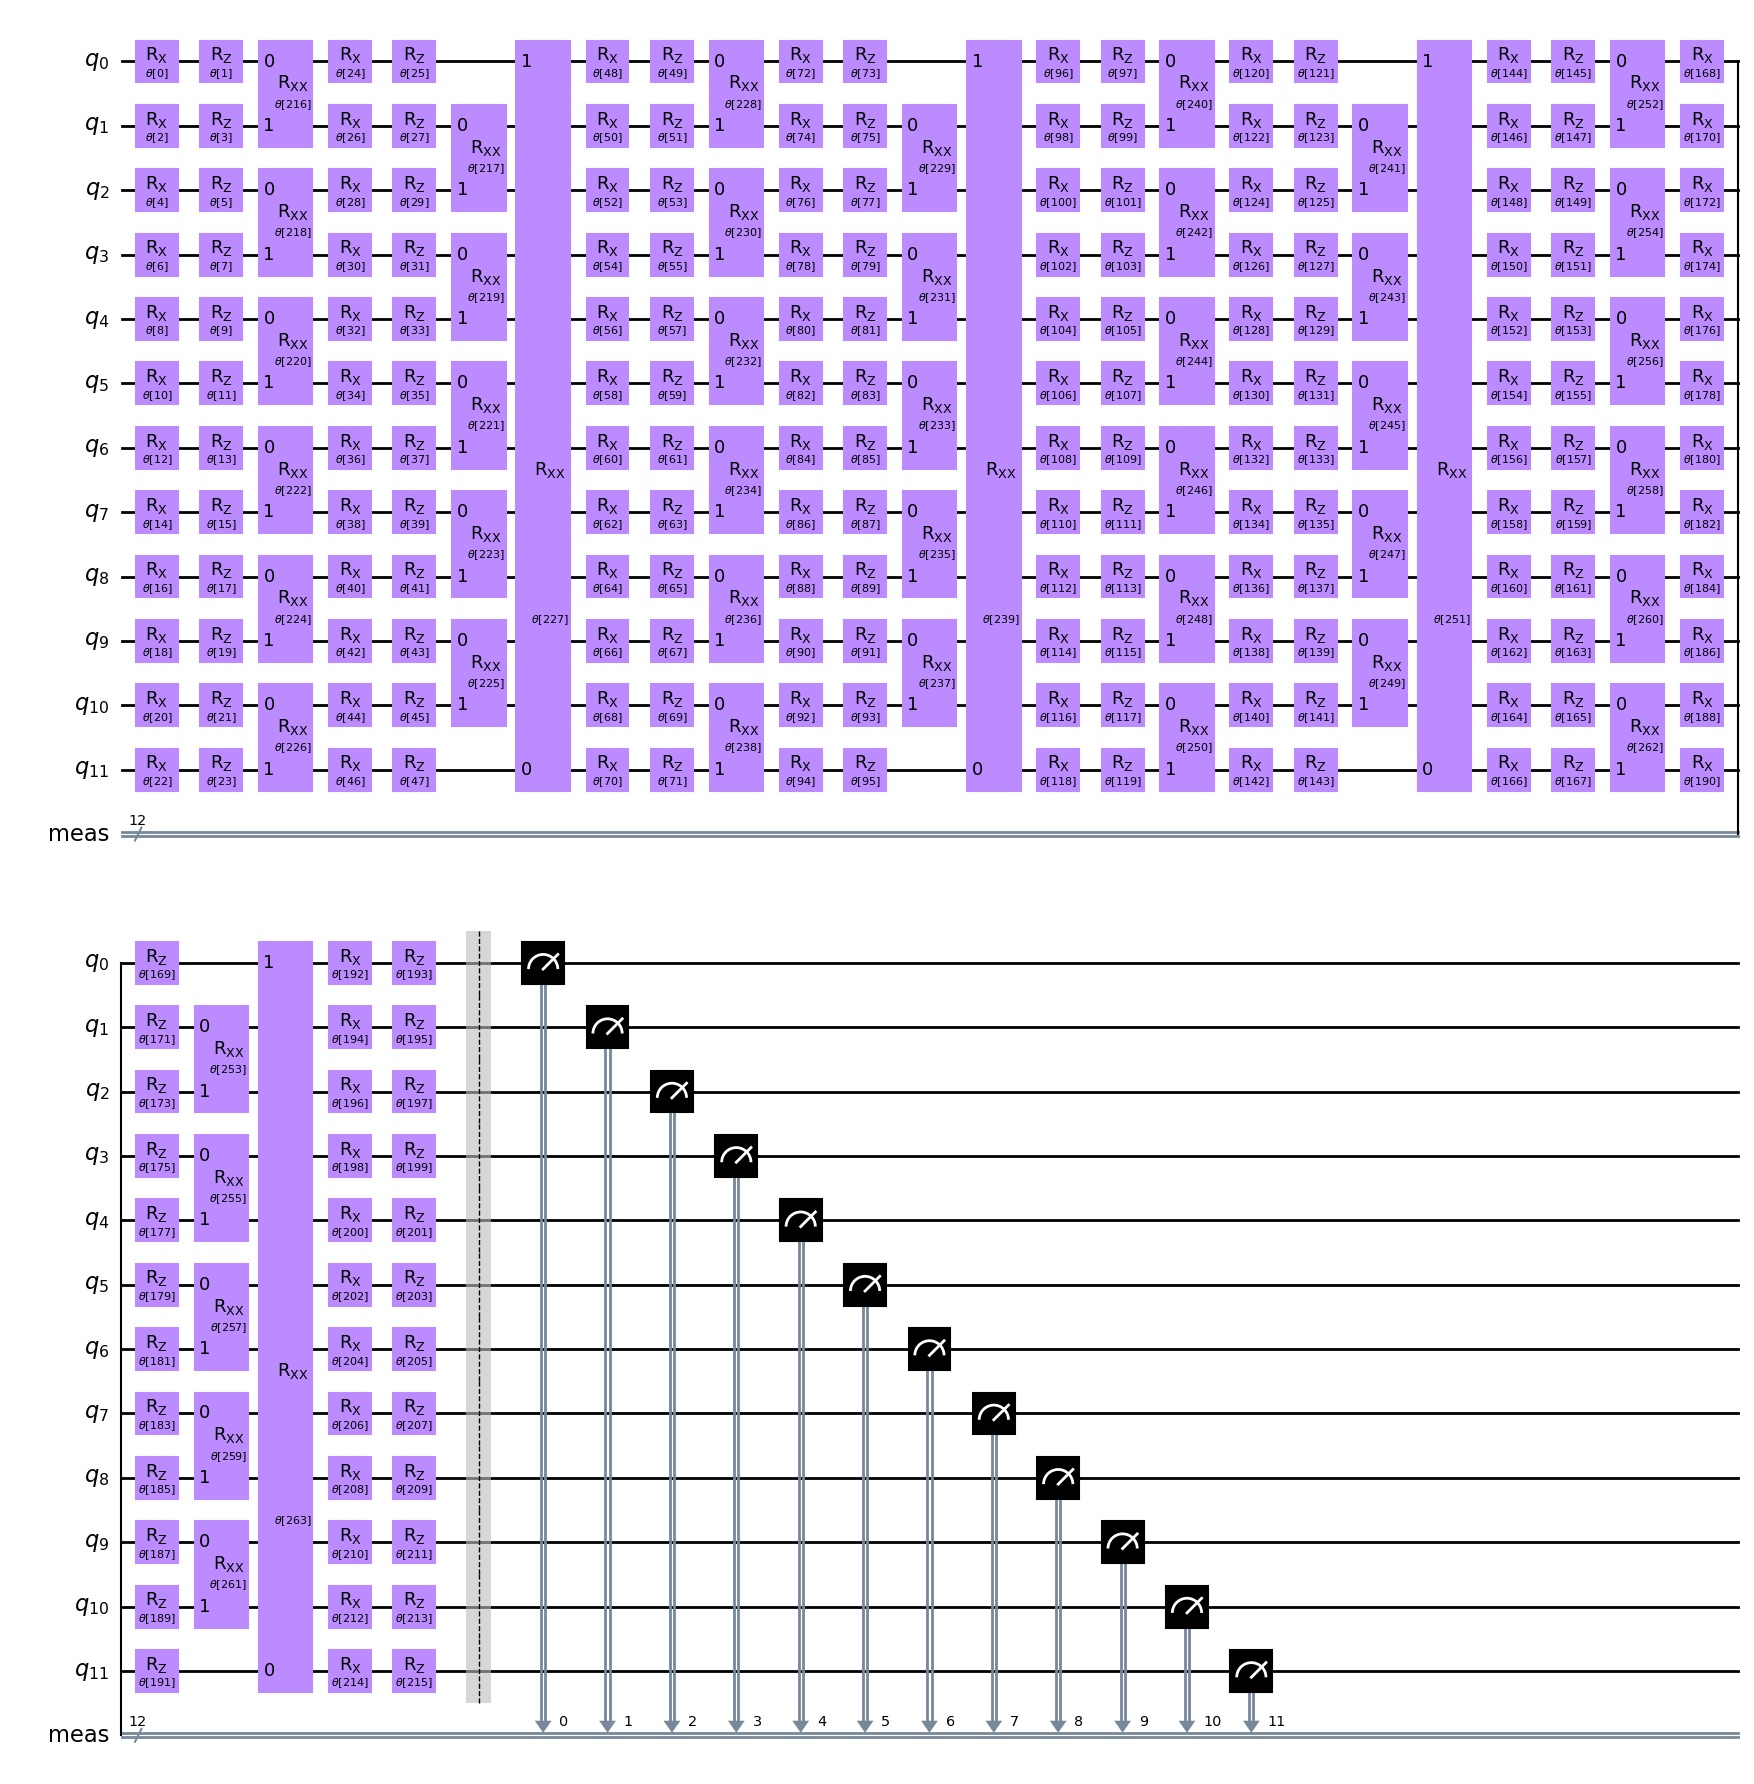

In [58]:
qc.draw(output="mpl", style="clifford")


In [59]:
# simulator = AerSimulator(device="GPU")
simulator = AerSimulator()
rng = np.random.default_rng()

In [60]:
def string_to_array(string):
    ls = []
    for c in string:
        ls.append(int(c))
    return ls

def key_convert(key):
    new_key = ""
    for i in range(0, len(key), 2):
        val = 2 * int(key[i]) + int(key[i+1])
        new_key += str(val)
    return new_key

def dict_to_ndarray(dict_data):
    data_array = []

    for result, count in dict_data.items():
        result = string_to_array(result)
        for i in range(count):
            data_array.append(result)
    return np.array(data_array)

def generate(parameters, shots):
    circuit = qc.assign_parameters({par_weights:parameters})
    job = simulator.run(circuit, shots=shots)
    result = job.result()
    counts_dict = result.get_counts()
    result_dict = {key_convert(key): val for key, val in counts_dict.items()}
    result_arr  = dict_to_ndarray(result_dict)
    result_arr_rescaled = result_arr * 1/4 + 1/8
    result_arr_spread   = result_arr_rescaled + rng.uniform(-1/8, 1/8, size=result_arr_rescaled.shape)
    return result_arr_spread


In [61]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 2.0)
        m.bias.data.uniform_(-1.0, 1.0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Linear(OUT_DIM, 32),
#             nn.LeakyReLU(0.2),
#             nn.Linear(32, 16),
#             nn.LeakyReLU(0.2),
#             nn.Linear(16, 8),
#             nn.LeakyReLU(0.2),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, input):
#         return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 12),
            nn.LeakyReLU(0.2),
            # nn.Linear(16, 8),
            # nn.LeakyReLU(0.2),
            nn.Linear(12, 6),
            nn.LeakyReLU(0.2),
            nn.Linear(6, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [62]:
# Create the discriminator
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# # Initialize BCELoss function
criterion = nn.BCELoss()

# def criterion(output, label):
#     return torch.mean(torch.square(output - label))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [63]:
# qc0 = qc.assign_parameters({par_weights:params})
# job = simulator.run(qc0, shots=16)
# count_dict = job.result().get_counts()

In [64]:
# count_dict

In [65]:
# generate(params, 10)

In [66]:
def updateD(real_batch, fake_batch):
    netD.zero_grad()
    real_batch = real_batch.to(device)
    b_size = real_batch.shape[0]
    label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
    output = netD(real_batch).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
    label.fill_(FAKE_LABEL)
    output = netD(fake_batch.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_g = output.mean().item()
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()
    return errD.item(), D_x, D_g


In [67]:
class GOptimizer:
    def __init__(self, alpha=spsa_alpha, gamma=spsa_gamma, c=spsa_c, A=spsa_A, a=spsa_a, netD=netD, gen=generate, loss_func = criterion, rng=rng):
        self.k = 0
        self.alpha = alpha
        self.gamma = gamma
        self.c     = c
        self.A     = A
        self.a     = a
        self.netD  = netD
        self.gen   = gen
        self.loss_func = loss_func
        self.rng = rng

    def calculate_loss(self, parameters, shots):
        fake_batch = self.gen(parameters, shots)
        fake_batch = torch.tensor(fake_batch, device=device, dtype=torch.float)
        with torch.no_grad():
            output = self.netD(fake_batch).view(-1)
        label = torch.full((shots,), REAL_LABEL, dtype=torch.float, device=device)
        return self.loss_func(output, label).item()

    def stochastic_gradient(self, parameters, shots):
        self.k += 1

        ck = self.c / self.k**self.gamma
        param_deltas = rng.choice([-1., 1.], size = parameters.shape) * ck
        params_plus = parameters + param_deltas
        params_minus = parameters - param_deltas

        loss_plus = self.calculate_loss(params_plus, shots)
        loss_minus = self.calculate_loss(params_minus, shots)

        return (loss_plus - loss_minus) / 2 / param_deltas

    def next_params(self, parameters, shots):
        grad = self.stochastic_gradient(parameters, shots)

        ak = self.a / (self.A + self.k) ** self.alpha
        return parameters - ak * grad




In [68]:
# # pretraining for discriminator
# for epoch in range(1):
#     for i, data in enumerate(data_loader):


#         # optimize the discriminator
#         data = data.to(device)
#         fake = generate(rng.standard_normal(n_parameters), shots=d_batch_size)
#         updateD(data, fake)

In [69]:
g_optimizer = GOptimizer()
params_init = rng.standard_normal(n_parameters)
params = params_init

In [70]:
for epoch in range(d_pretrain_epoch):
    for i, data in enumerate(data_loader):
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=d_batch_size)
        loss_D, D_x, D_g = updateD(data, fake)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x6 and 4x12)

In [ ]:
G_losses = []
D_losses = []

start = time.time()
now = start

print("Starting Training Loop...")

for epoch in range(n_epoch):
    for i, data in enumerate(data_loader):


        
        # optimize the discriminator
        data = data.to(device)
        fake = generate(params, shots=d_batch_size)
        for j in range(d_repeats):
            loss_D, D_x, D_g = updateD(data, fake)

        # this part is not important
        with torch.no_grad():
            output = netD(torch.tensor(fake, device=device, dtype=torch.float)).view(-1)
            labels = torch.full((fake.shape[0],), REAL_LABEL, dtype=torch.float, device=device)
            loss_G = criterion(output, labels)


        if epoch < epoch_1:
            g_repeats = g_repeats_1
        else:
            g_repeats = g_repeats_2
        # optimize the generator
        for j in range(g_repeats):
            params = g_optimizer.next_params(params, g_batch_size)


        # print output
        if i%10 == 0:
            G_losses.append(loss_G)
            D_losses.append(loss_D)

            last, now = now, time.time()
            print(f"[{epoch+1}/{n_epoch}][{i}/{len(data_loader)}]\tLossD: {loss_D:.4f}\tLossG: {loss_G:.4f}\t" +
                f"D(x): {D_x:.4f}\tD(G(x)): {D_g:.4f}\tTime: {now-last:.1f}s")

Starting Training Loop...
[1/20][0/640]	LossD: 0.8628	LossG: 2.0989	D(x): 0.6575	D(G(x)): 0.1921	Time: 0.0s
[1/20][10/640]	LossD: 0.6889	LossG: 2.5731	D(x): 0.8062	D(G(x)): 0.2067	Time: 0.1s
[1/20][20/640]	LossD: 0.6610	LossG: 3.4246	D(x): 0.7213	D(G(x)): 0.1793	Time: 0.1s
[1/20][30/640]	LossD: 1.0673	LossG: 3.0250	D(x): 0.6397	D(G(x)): 0.2639	Time: 0.1s
[1/20][40/640]	LossD: 0.9595	LossG: 1.8145	D(x): 0.6888	D(G(x)): 0.3140	Time: 0.1s
[1/20][50/640]	LossD: 0.8524	LossG: 2.2863	D(x): 0.7397	D(G(x)): 0.2914	Time: 0.1s
[1/20][60/640]	LossD: 0.9407	LossG: 1.7998	D(x): 0.8240	D(G(x)): 0.3563	Time: 0.1s
[1/20][70/640]	LossD: 0.8638	LossG: 1.5207	D(x): 0.7556	D(G(x)): 0.3383	Time: 0.1s
[1/20][80/640]	LossD: 0.9234	LossG: 1.9604	D(x): 0.7102	D(G(x)): 0.2642	Time: 0.1s
[1/20][90/640]	LossD: 0.6034	LossG: 2.2136	D(x): 0.7627	D(G(x)): 0.2244	Time: 0.1s
[1/20][100/640]	LossD: 0.9166	LossG: 2.4480	D(x): 0.6229	D(G(x)): 0.1675	Time: 0.1s
[1/20][110/640]	LossD: 0.8929	LossG: 2.1269	D(x): 0.7137	D(G(

In [ ]:
finish = time.time()
print(f"Training takes {round(finish-start)}s.")

Training takes 331s.


In [ ]:
print(params)

[ 7.38642049e-01 -2.63028187e-01 -1.18318526e+00 -3.51692165e-01
  3.05205441e-01 -8.08184331e-01  5.07362164e-01 -8.87326651e-01
  6.34644742e-01 -1.48460792e+00  6.28784305e-01 -4.84530129e-01
 -5.96340379e-01 -1.16100519e+00  2.76732831e-01  1.02482536e+00
 -5.91156158e-01 -3.41454936e-01 -4.18012810e-01  1.03804915e+00
  2.24958743e-02 -1.05676673e+00  3.54728763e-01  1.11652483e-01
  4.39750481e-01  7.13508351e-01  1.53629119e-01 -2.01829225e+00
  8.71894109e-01 -1.57453133e+00 -5.62977220e-01 -1.20882688e-01
  9.66245957e-01  1.22032704e+00  3.90839101e-01 -4.24040150e-01
 -5.37705515e-01 -1.19709828e+00  4.42052723e-01 -4.90663936e-01
  3.07391148e-01  4.42631172e-01 -7.30316073e-01 -1.86247259e+00
  7.48456908e-01  1.15226485e+00 -2.44213607e-01  3.69915612e-01
  7.53867581e-01 -5.71814029e-01 -7.76952736e-01  2.78714683e-01
 -1.84910437e+00 -2.72477409e-01  8.39823563e-01 -6.12406225e-02
 -1.05928389e+00 -1.14126086e+00 -2.69558923e-01  4.17674206e-01
  1.43510257e+00  1.50497

In [ ]:
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=12, out_features=6, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

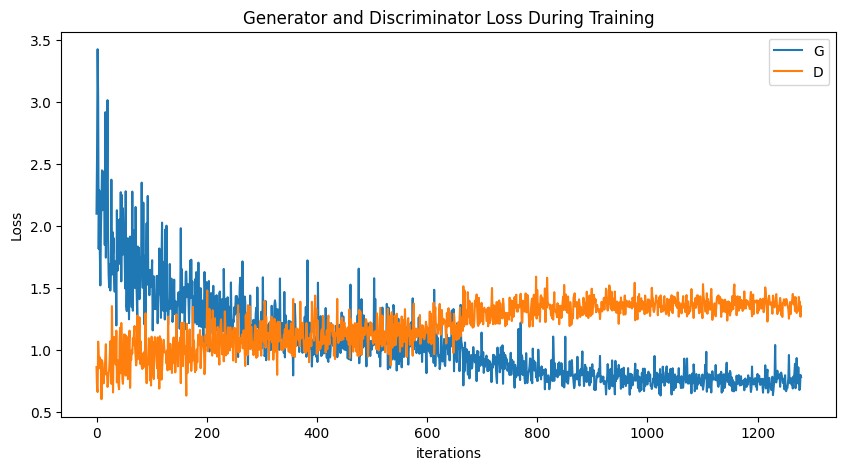

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(os.path.join(save_folder, "loss.png"))

In [ ]:
n_rows = 4
n_cols = 4

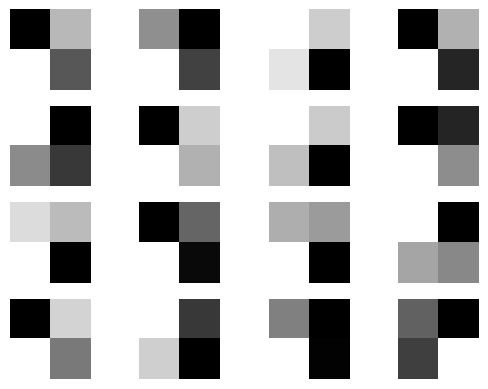

In [ ]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")
fig.savefig(os.path.join(save_folder, "real_images.png"))


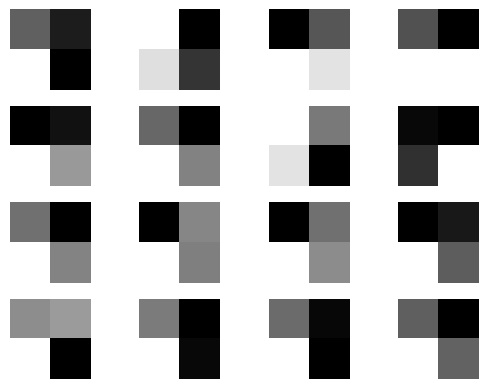

In [ ]:
real_batch = next(iter(data_loader))

fig, axes = plt.subplots(n_rows, n_cols)

for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(real_batch[i].reshape(2, 2).cpu(), cmap="binary")

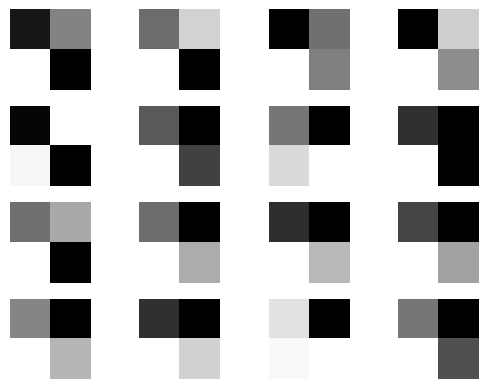

In [ ]:
b_size = n_rows * n_cols

fake_batch = generate(params, b_size)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2), cmap="binary")
fig.savefig(os.path.join(save_folder, "fake_images.png"))


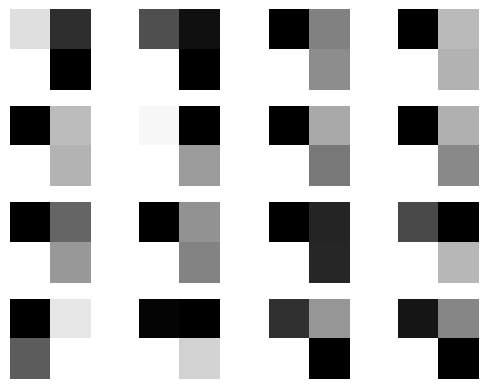

In [ ]:
b_size = n_rows * n_cols

fake_batch = generate(params, b_size)

fig, axes = plt.subplots(n_rows, n_cols)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    ax.imshow(fake_batch[i].reshape(2, 2), cmap="binary")

In [ ]:
sample_size = 10000
data_index = torch.randperm(data_true.shape[0])[:sample_size]
real_samples = data_true[data_index]

fake_samples = generate(params, sample_size)

np.savez(save_folder + "/samples.npz", 
    real_samples = real_samples.cpu(), 
    fake_samples = fake_samples
)

In [ ]:
with torch.no_grad():
    real_scores = netD(real_samples).cpu()
    fake_scores = netD(torch.tensor(fake_samples, device=device, dtype=torch.float)).cpu()

In [ ]:
print(np.mean(real_scores.numpy()))
print(np.mean(fake_scores.numpy()))


0.537769
0.5089203


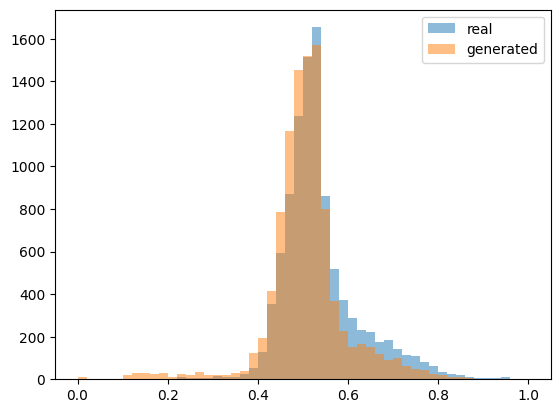

In [ ]:
fig, ax = plt.subplots()



ax.hist(real_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="real")
ax.hist(fake_scores.view(-1), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")

ax.legend()

fig.savefig(os.path.join(save_folder, "hist.png"))


In [ ]:
for p in netD.parameters():
    print(p)

Parameter containing:
tensor([[-2.3201,  0.4992,  2.4478,  5.2262],
        [-1.8283,  2.3149, -0.6818,  0.3190],
        [ 0.5779,  0.6804,  2.1527,  4.7594],
        [ 0.3332, -0.5693, -1.6900,  0.2102],
        [ 1.7413,  1.4819,  1.1412,  0.9003],
        [-2.0052,  1.2120, -1.9704,  0.8447],
        [ 2.3475,  1.1285,  0.0507, -2.7165],
        [ 1.8708,  0.5520, -0.1272,  1.4568],
        [ 0.4612, -3.0526, -0.8197,  0.5477],
        [ 0.5565, -0.5244,  2.5955,  0.4396],
        [ 1.9844,  3.8230, -1.9882, -0.4821],
        [-2.3646, -2.6147,  2.1290, -0.8450]], requires_grad=True)
Parameter containing:
tensor([ 1.2570, -0.3433, -0.7275, -0.0508, -0.4103,  0.1857,  1.4350, -0.3363,
        -0.3431, -0.1639, -0.6071,  0.5132], requires_grad=True)
Parameter containing:
tensor([[-0.2026,  1.5131, -1.5439, -1.2315, -1.0619, -0.0128,  1.7521, -2.6374,
          3.7766,  1.8045, -1.8505, -0.2982],
        [ 0.8074,  0.6916, -0.7645, -0.6474,  0.0919, -5.0869, -3.3881, -1.4665,
        

In [ ]:
# json_path = data_path[:-4] + ".json"
# with open(json_path, 'r') as f:
#     real_data_dict = json.load(f)

# def np_to_dict(result_np):
#     result_dict = {}
#     for line in result_np:
#         str_key = ""
#         for i in line:  # reversing the order to match qiskit notation
#             str_key+=(str(i))
#         current_value = result_dict.get(str_key, 0)
#         result_dict[str_key] = current_value + 1
#     return result_dict

# fake_data = generate(params, 20480)

# fake_data_dict = np_to_dict(fake_data)

# all_keys = (set(real_data_dict.keys())) | (set(fake_data_dict.keys()))

# real_counts = []
# fake_counts = []

# for k in all_keys:
#     real_counts.append(real_data_dict.get(k, 0))
#     fake_counts.append(fake_data_dict.get(k, 0))

# real_counts = np.array(real_counts)
# fake_counts = np.array(fake_counts)

# real_probs = real_counts / np.sum(real_counts)
# fake_probs = fake_counts / np.sum(fake_counts)

# mixed_probs = (real_probs + fake_probs) / 2 # here, every entry of mixed_probs are positive

# # Note, mixed_probs is all positive. That's why you can use nan_to_num to deal with zero entries in real_probs or fake_probs
# dl_r = np.sum(real_probs * np.nan_to_num(np.log(real_probs / mixed_probs)))
# dl_f = np.sum(fake_probs * np.nan_to_num(np.log(fake_probs / mixed_probs)))

# jl_div = (dl_r + dl_f) / 2

# print(f"JL-divergens is {jl_div}")


In [ ]:
# train a standalone discriminator to evaluate the performance of the GAN "objectively"
class Evaluator(nn.Module):
    def __init__(self):
        super(Evaluator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(OUT_DIM, 16),
            # nn.LeakyReLU(0.2),
            # nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
netEv = Evaluator().to(device)
netEv.apply(weights_init)

optimizer_ev = optim.Adam(netEv.parameters(), lr=lr, betas=(0.5, 0.999))
loss_ev = nn.BCELoss()
print(netEv)

Evaluator(
  (main): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
batch_size_ev = 16

In [ ]:
real_samples_np = real_samples.cpu().numpy()
fake_samples_np = fake_samples

samples = np.concatenate((real_samples_np, fake_samples_np))

real_labels = np.repeat(REAL_LABEL, real_samples_np.shape[0])
fake_labels = np.repeat(FAKE_LABEL, fake_samples_np.shape[0])
labels = np.concatenate((real_labels, fake_labels))

X_train, X_rest, y_train, y_rest = train_test_split(
    samples, labels, train_size = 0.6, shuffle = True, stratify = labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rest, y_rest, test_size = 0.5, shuffle = True, stratify = y_rest
)

X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
y_valid = torch.tensor(y_valid, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)


data_loader_ev = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size = batch_size_ev, shuffle = True)


In [ ]:
valid_losses = []
train_losses = []
iters = 0

netEv.train()
 

print("Starting the training loop")
for epoch in range(n_epoch):
    for i, data in enumerate(data_loader_ev):
        netEv.zero_grad()
        X_batch = data[0].to(device)
        y_batch = data[1].to(device)
        prediction_batch = netEv(X_batch).view(-1)
        err = loss_ev(prediction_batch, y_batch)
        err.backward()
        optimizer_ev.step()

        if i%50 == 0:
            netEv.eval()
            with torch.no_grad():
                prediction_valid = netEv(X_valid).view(-1)
                prediction_train = netEv(X_train).view(-1)
            train_loss = loss_ev(prediction_train, y_train).item()
            valid_loss = loss_ev(prediction_valid, y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_acc  = torch.isclose(torch.round(prediction_valid), y_valid).sum().item()/len(y_valid)
            netEv.train()

            print(
                f"[{epoch}/{n_epoch}][{i}/{len(data_loader)}]\tLoss train: {train_loss:.3f}\tLoss valid: {valid_loss:.3f}\tLoss acc: {valid_acc:.3f}"
            )

Starting the training loop
[0/20][0/640]	Loss train: 32.538	Loss valid: 32.971	Loss acc: 0.500
[0/20][50/640]	Loss train: 16.435	Loss valid: 16.737	Loss acc: 0.500
[0/20][100/640]	Loss train: 1.922	Loss valid: 1.973	Loss acc: 0.482
[0/20][150/640]	Loss train: 1.047	Loss valid: 1.049	Loss acc: 0.506
[0/20][200/640]	Loss train: 0.823	Loss valid: 0.814	Loss acc: 0.537
[0/20][250/640]	Loss train: 0.794	Loss valid: 0.784	Loss acc: 0.539
[0/20][300/640]	Loss train: 0.831	Loss valid: 0.824	Loss acc: 0.508
[0/20][350/640]	Loss train: 0.760	Loss valid: 0.751	Loss acc: 0.546
[0/20][400/640]	Loss train: 0.752	Loss valid: 0.743	Loss acc: 0.543
[0/20][450/640]	Loss train: 0.904	Loss valid: 0.899	Loss acc: 0.513
[0/20][500/640]	Loss train: 0.739	Loss valid: 0.732	Loss acc: 0.550
[0/20][550/640]	Loss train: 0.755	Loss valid: 0.746	Loss acc: 0.537
[0/20][600/640]	Loss train: 0.744	Loss valid: 0.735	Loss acc: 0.537
[0/20][650/640]	Loss train: 0.750	Loss valid: 0.741	Loss acc: 0.540
[0/20][700/640]	Loss

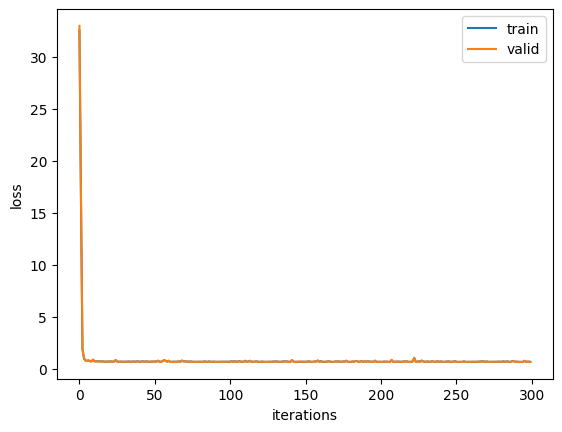

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.set(xlabel="iterations", ylabel="loss")
ax.legend()

In [ ]:
netEv.eval()

with torch.no_grad():
    prediction_test = netEv(X_test).view(-1)

test_acc = torch.isclose(torch.round(prediction_test), y_test).sum().item() / len(y_test)

print(f"Test accuracy: {test_acc}")

Test accuracy: 0.53725


In [ ]:
print(f"AUC score is {roc_auc_score(y_test, prediction_test)}")

AUC score is 0.55173075


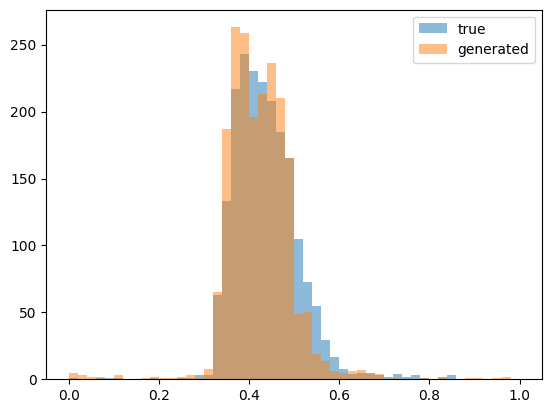

In [ ]:
true_indices = y_test.isclose(torch.tensor(1.0))
fake_indices = y_test.isclose(torch.tensor(0.0))

pred_true = prediction_test[true_indices]
pred_fake = prediction_test[fake_indices]

fig, ax = plt.subplots()
ax.hist(pred_true.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(0), alpha=0.5, label="true")
ax.hist(pred_fake.cpu(), bins = 50, range=(0, 1), color = plt.cm.tab10(1), alpha=0.5, label="generated")
ax.legend()

None